### Todos:
- [ ] Textzellen-überarbeiten
- [ ] Hyperparameter-Tuning
- [ ] Schauen ob two-feature-goal-corr irgendwo dazupasst
- [ ] handling outliers vor shot-analysis

Todo: Outlook and summary on what will be analysed in this notebook.

## Import of libraries and data 

In [1]:
# Standard libraries imports
from itertools import chain
import json
import math

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Machine learning
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

# Custom assets, constants, utils and visualizations
import config as co
import utils as ut
import visualizations as vis

We start off by importing each competition's event- and match-data and creating dataframes from them.

In [2]:
dfs_events = {}
dfs_matches = {}
events = {}
matches = {}

competitions = [
    'england', 'european_championship', 'france',
    'germany', 'italy', 'spain', 'world_cup'
]

for competition in competitions:
    with open(
        f'data/events/events_{competition}.json',
        encoding='utf-8'
    ) as json_file:
        events[competition] = json.load(json_file)
        dfs_events[competition] = pd.DataFrame(events[competition])
        dfs_events[competition]['competition'] = competition
        print(
            f'{competition}: '
            f'{dfs_events[competition].shape[0]} events loaded.'
        )

    with open(
        f'data/matches/matches_{competition}.json',
        encoding='utf-8'
    ) as json_file:
        matches[competition] = json.load(json_file)
        dfs_matches[competition] = pd.DataFrame(matches[competition])
        dfs_matches[competition]['competition'] = competition
        print(
            f'{competition}: '
            f'{dfs_matches[competition].shape[0]} matches loaded.'
        )

df_events = pd.concat(
    [pd.DataFrame(dfs_events[competition]) for competition in competitions]
).reset_index()

df_matches = pd.concat(
    [pd.DataFrame(dfs_matches[competition]) for competition in competitions]
)
df_matches.set_index('wyId', inplace=True)

england: 643150 events loaded.
england: 380 matches loaded.
european_championship: 78140 events loaded.
european_championship: 51 matches loaded.
france: 632807 events loaded.
france: 380 matches loaded.
germany: 519407 events loaded.
germany: 306 matches loaded.
italy: 647372 events loaded.
italy: 380 matches loaded.
spain: 628659 events loaded.
spain: 380 matches loaded.
world_cup: 101759 events loaded.
world_cup: 64 matches loaded.


We import some more data, such as player-/team-data and tag-mappings.

In [3]:
df_tag_labels = pd.read_csv('data/mappings/tags2name.csv')
df_tag_labels.set_index('Tag', inplace=True)
df_event_labels = pd.read_csv('data/mappings/eventid2name.csv')

In [4]:
with open('data/players.json', encoding='utf-8') as json_file:
    players = json.load(json_file)

df_players = pd.json_normalize(players)
df_players.set_index('wyId', inplace=True)

In [5]:
with open('data/teams.json', encoding='utf-8') as json_file:
    teams_raw = json_file.read().encode().decode('unicode_escape')
    teams = json.loads(teams_raw)

df_teams = pd.DataFrame(teams)
df_teams.set_index('wyId', inplace=True)

## Basic Cleaning

Some events' playerId is 0 and therefore cannot be matched with a player from the database. Let's drop those entries.

In [6]:
missing_player_id = df_events[df_events['playerId'] == 0].index
df_events.drop(missing_player_id, inplace=True)
print(
    f'{len(missing_player_id)} events with unrecorded playerId removed.'
)

226038 events with unrecorded playerId removed.


## Feature engineering

We can simplify the 'tags'-column by flattening and unpacking the dictionaries to a list.

In [7]:
df_events['tags'] = df_events['tags'].apply(
    lambda x: list(chain.from_iterable(d.values() for d in x))
)

The 'positions'-column can be split up for easier access.

In [8]:
df_events['xPosStart'] = df_events['positions'].apply(
    lambda x: x[0]['x']
)

df_events['yPosStart'] = df_events['positions'].apply(
    lambda x: x[0]['y']
)

df_events['xPosEnd'] = df_events['positions'].apply(
    lambda x: x[1]['x'] if len(x) == 2 else x[0]['x']
)

df_events['yPosEnd'] = df_events['positions'].apply(
    lambda x: x[1]['y'] if len(x) == 2 else x[0]['y']
)

df_events.drop(
    columns=['positions'],
    inplace=True
)

### Distance

We can now calculate distance between start- and end-position.

In [9]:
df_events['distance'] = df_events.apply(
    lambda row: np.linalg.norm(
        (
            (row['xPosEnd'] - row['xPosStart']) * co.PITCH_LENGTH / 100,
            (row['yPosEnd'] - row['yPosStart']) * co.PITCH_WIDTH / 100
        )
    ),
    axis=1
)

There are some events in the dataframe with 0m distance (maybe they were too short to have differing start- and end-position). Let's drop them, as they would cause problems when calculating passing-angles.

In [10]:
events_with_zero_distance = df_events[df_events['distance'] == 0].index
df_events.drop(events_with_zero_distance, inplace=True)

print(
    f'{len(events_with_zero_distance)} events with zero distance removed.'
)

10359 events with zero distance removed.


With some helper-functions we can calulate the shortest distance to the goal before and after the event.

In [11]:
def y_closest_goal(y: float) -> float:
    if y < co.Y_LEFT_POST:
        y_closest = co.Y_LEFT_POST
    elif y > co.Y_RIGHT_POST:
        y_closest = co.Y_RIGHT_POST
    else:
        y_closest = y
    return y_closest

def distance_to_goal(x: float, y: float) -> float:
    vector_to_goal = (
        (100 - x) * co.PITCH_LENGTH / 100,
        (y_closest_goal(y) - y) * co.PITCH_WIDTH / 100
    )
    return np.linalg.norm(vector_to_goal)

In [12]:
df_events['goalDistanceStart'] = df_events.apply(
    lambda row: distance_to_goal(row['xPosStart'], row['yPosStart']),
    axis=1
)

df_events['goalDistanceEnd'] = df_events.apply(
    lambda row: distance_to_goal(row['xPosEnd'], row['yPosEnd']),
    axis=1
)

df_events['goalDistanceCovered'] = (
    df_events['goalDistanceEnd'] - df_events['goalDistanceStart']
)

Let's tag events that started outside and ended inside the final third. This will be an interesting feature when analysing passes later.

In [13]:
df_events['intoFinalThird'] = (
    (df_events['xPosStart'] < 66.67) &
    (df_events['xPosEnd'] >= 66.67)
)

### Angles

Each events' angle can be deducted by it's start- and end-position. This will be an important feature for the pass-analysis as well.

In [14]:
def angle(u: tuple, v: tuple) -> float:
    dot_prod = np.dot(u, v)
    u_norm = np.linalg.norm(u)
    v_norm = np.linalg.norm(v)
    return math.degrees(
        math.acos(dot_prod / (u_norm * v_norm))
    )

In [15]:
df_events['angle'] = df_events.apply(
    lambda row: angle(
        (
            (row['xPosEnd'] - row['xPosStart']) * co.PITCH_LENGTH / 100,
            (row['yPosEnd'] - row['yPosStart']) * co.PITCH_WIDTH / 100
        ),
        (1, 0)
    ),
    axis=1
)

We can group together the angles into different categories.

In [16]:
bins = [0, 22.5, 67.5, 112.5, 157.5, 180]

labels = [
    'vertical forward',
    'diagonal forward',
    'horizontal',
    'diagonal backward',
    'vertical backward'
]

df_events['angleCategory'] = pd.cut(
    df_events['angle'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    ordered=False
)

We can also get each event's angle to the goal before and after the event by calculating the angle of the vector from the event's position to the closest point of the goal. This will be an important feature when inspecting shots.

In [17]:
def angle_to_goal(x: float, y: float) -> float:
    vector_to_goal = (
        (100 - x) * co.PITCH_LENGTH / 100,
        (y_closest_goal(y) - y) * co.PITCH_WIDTH / 100
    )
    return angle(
        vector_to_goal,
        (1, 0)
    ) if not vector_to_goal == (0, 0) else 0

In [18]:
df_events['goalAngleStart'] = df_events.apply(
    lambda row: angle_to_goal(row['xPosStart'], row['yPosStart']),
    axis=1
)

df_events['goalAngleEnd'] = df_events.apply(
    lambda row: angle_to_goal(row['xPosEnd'], row['yPosEnd']),
    axis=1
)

As an alternative approach of defining a positions angle to the goal, we define a position's 'shot-window' as the angle between the vectors from the event's position to each of the posts.

In [19]:
def shot_window(x: float, y: float) -> float:
    left = (
        (100 - x) * co.PITCH_LENGTH / 100,
        (co.Y_LEFT_POST - y) * co.PITCH_WIDTH / 100
    )

    right = (
        (100 - x) * co.PITCH_LENGTH / 100,
        (co.Y_RIGHT_POST - y) * co.PITCH_WIDTH / 100
    )

    return angle(left, right)

In [20]:
df_events['shotWindow'] = df_events.apply(
    lambda row: shot_window(row['xPosStart'], row['yPosStart']),
    axis=1
)

### Tags

If applicable, we can extract the information with which bodypart the event was carried out and if it was the strong/weak foot by checking the player-data.

In [21]:
def label_bodyPart(tags: list, strong_foot: str) -> str:
    relevant_tags = [401, 402, 403]
    filtered_tags = list(set(tags) & set(relevant_tags))
    if len(filtered_tags) > 0:
        bodyPart = df_tag_labels.loc[filtered_tags[0], 'Label'].lower()
        if bodyPart == 'head/body':
            label = bodyPart
        elif bodyPart == strong_foot:
            label = 'strong foot'
        else:
            label = 'weak foot'
    else:
        label = 'unknown'
    return label

In [22]:
df_events['bodyPart'] = df_events.apply(
    lambda row: label_bodyPart(
        row['tags'],
        df_players.loc[row['playerId'], 'foot']
    ),
    axis=1
)

For each event we extract the role the player plays in (goalkeeper, defender, midfielder or forward).

In [23]:
df_events['playerRole'] = df_events.apply(
    lambda row: df_players.loc[row['playerId'], 'role.code3'],
    axis=1
)

For shot-events, we can extract information about which part of the goal the shot was aimed at from the tags.

In [24]:
def label_tags(tags: list, relevant_tags: list) -> str:
    filtered_tags = list(set(tags) & set(relevant_tags))
    if len(filtered_tags) > 0:
        label = df_tag_labels.loc[filtered_tags[0], 'Label'].lower()
    else:
        label = 'unknown'
    return label

In [25]:
df_events['aimedGoalPart'] = df_events['tags'].apply(
    lambda x: label_tags(x, list(range(1201, 1224)))
)

Using the tag-mapping, we can create some more tag-flags.

In [26]:
tag_mappings = {
    'keyPass': 302,
    'dangerousBallLost': 2001,
    'opportunity': 201,
    'counterAttack': 1901,
    'through': 901,
    'high': 801
}

for col, tag_id in tag_mappings.items():
    df_events[col] = df_events['tags'].apply(
        lambda x: tag_id in x
    )

df_events['accurate'] = df_events['tags'].apply(
    lambda x: True if 1801 in x else False if 1802 in x else None
)

df_events['goal'] = df_events['tags'].apply(
    lambda x: 101 in x or 102 in x
)

We finish the feature-engineering part by providing some information about the previous event. It might be interesting for shot-analysis later on to see the effect of the type of the preceding event (e.g. high/low pass or dribble) on the shot's outcome. For simplicity we just shift the columns of interest by one and disregard the edge cases (each match-half's first and last event), as they are not interesting.

In [27]:
cols_shift = [
    'eventId', 'eventName', 'subEventId', 'subEventName',
    'distance', 'angle', 'angleCategory', 'dangerousBallLost',
    'keyPass', 'through', 'high'
]

df_events[
    [f'prev{col[0].capitalize()}{col[1:]}' for col in cols_shift]
] = df_events[cols_shift].shift(1)

## Pass analysis

Let's compare all the players' passing-skills based on 3 features: average passing-accuracy, forward rate and share of passes into the final third.

In [28]:
pass_stats = df_events[
    df_events['eventName'] == 'Pass'
].groupby('playerId').agg({
    'id': 'count',
    'accurate': 'mean',
    'angleCategory': lambda x: (
        (x == 'diagonal forward') |
        (x == 'vertical forward')
    ).mean(),
    'intoFinalThird': 'mean'
}).rename(
    columns={
        'accurate': 'passingAccuracy',
        'angleCategory': 'forwardRate',
        'id': 'passCount'
    }
)
overlap_cols = set(df_players.columns) & set(pass_stats.columns)
df_players = df_players.drop(columns=overlap_cols)
df_players = df_players.join(
    pass_stats,
    how='left'
)

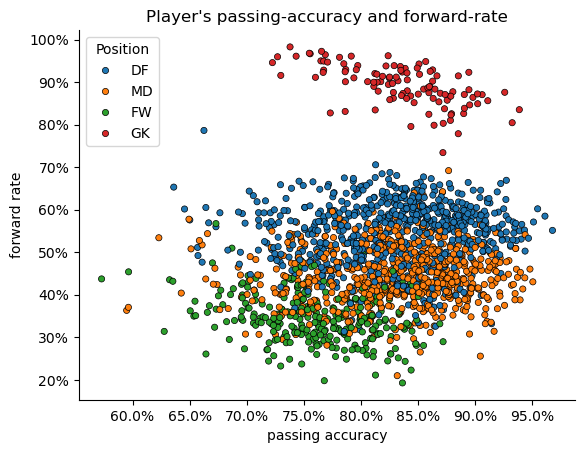

In [29]:
relevant_passers = df_players[df_players['passCount'] >= 250]
sns.scatterplot(
    data=relevant_passers,
    x='passingAccuracy',
    y='forwardRate',
    hue='role.code2',
    s=20,
    edgecolor='black',
    linewidth=0.5
)
sns.despine(right=True, top=True)
plt.title(
    'Player\'s passing-accuracy and forward-rate'
)
plt.xlabel('passing accuracy')
plt.ylabel('forward rate')
plt.legend(title='Position')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

As we can see, the passing-profile highly depends on the player's position: The average passing-accuracy and forward-rate decreases with the player's position being more forward on the pitch, as there is more direct pressure from opponents and less opportunities to find a forward-pass. Unsurprisingly, the top-tier of passers (excluding goalkeepers) are almost all playing in defense.

In [30]:
top_tier_passers = df_players[
    (df_players['passCount'] >= 1000) &
    (df_players['role.code2'] != 'GK') &
    (df_players['passingAccuracy'] >= 0.9) &
    (df_players['forwardRate'] >= 0.5)
]
print(top_tier_passers['role.code2'].value_counts())

role.code2
DF    53
MD     4
Name: count, dtype: int64


Let's now dive deeper into the top-tier of passers, considering only field-players with both high passing-accuracy and forward-rate. In this top-tier, we want to find the best three for each of the passing-features.

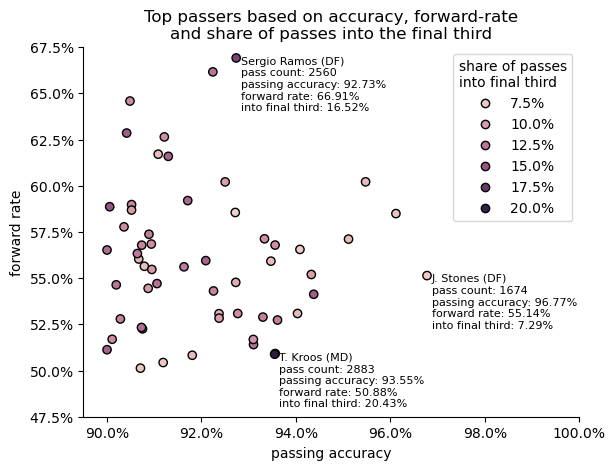

In [ ]:
sns.scatterplot(
    data=top_tier_passers,
    x='passingAccuracy',
    y='forwardRate',
    hue='intoFinalThird',
    edgecolor='black',
    linewidth=1
)
for col in ['passingAccuracy', 'forwardRate', 'intoFinalThird']:
    player_id = top_tier_passers[col].idxmax()
    player_name = df_players.loc[player_id, 'shortName']
    player_role = df_players.loc[player_id, 'role.code2']
    pass_count = df_players.loc[player_id, 'passCount']
    intoFinalThird = df_players.loc[player_id, 'intoFinalThird']
    passing_accuracy = df_players.loc[player_id, 'passingAccuracy']
    forward_rate = df_players.loc[player_id, 'forwardRate']
    annotation_text = (
        f'{player_name} ({player_role})\n'
        f'pass count: {int(pass_count)}\n'
        f'passing accuracy: {passing_accuracy * 100:.2f}%\n'
        f'forward rate: {forward_rate * 100:.2f}%\n'
        f'into final third: {intoFinalThird * 100:.2f}%\n'
    )
    plt.annotate(
        annotation_text,
        (passing_accuracy + 0.001, forward_rate + 0.001),
        fontsize=8,
        va='top',
        ha='left'
    )
sns.despine(right=True, top=True)
plt.xlim(0.895, 1)
plt.ylim(0.475, 0.675)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title(
    'Top passers based on accuracy, forward-rate\n' +
    'and share of passes into the final third'
)
plt.xlabel('passing accuracy')
plt.ylabel('forward rate')
handles, labels = plt.gca().get_legend_handles_labels()
percent_labels = [f'{float(label)*100:.1f}%'for label in labels]
plt.legend(handles, percent_labels,
    title='share of passes\ninto final third'
)
plt.show()

Based on the criteria of passsing accuray, forward rate and share of passes into final-third, the three best passers from the top tier are Sergio Ramos, John Stones and Toni Kroos. Especially Toni Kroos stands out as one of only 4 midfielders in this top-tier-category.

To get a better idea of the these players' passing-profiles, let's take a look at all of their passes in one of their matches, starting with Sergio Ramos.

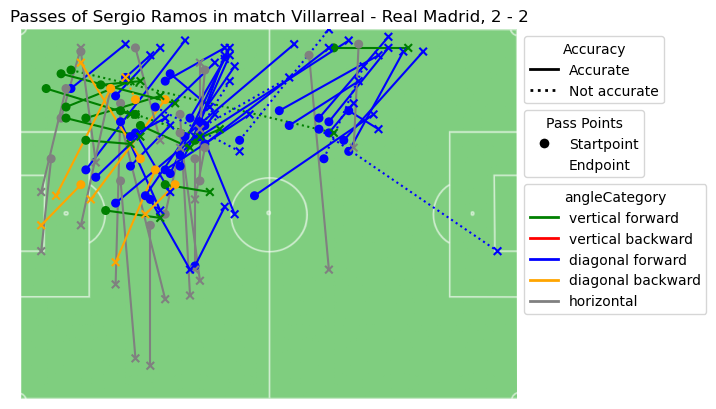

In [32]:
vis.plot_passes(
    df_events,
    df_players,
    df_matches,
    3306,
    2565927,
    'angleCategory'
)

As we can see, Ramos played as a left center-back in that game. Based on his passes, he stayed in his defensive position most of the game, with only a few passes in the opponent's half.

Next up is Toni Kroos against Celta de Vigo.

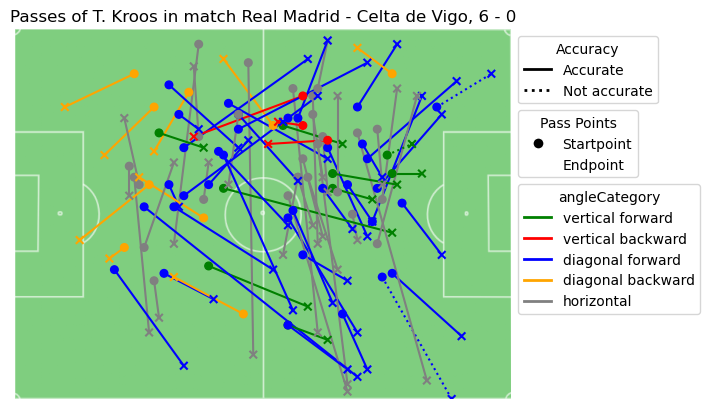

In [33]:
vis.plot_passes(
    df_events,
    df_players,
    df_matches,
    14723,
    2565912,
    'angleCategory'
)

Typical for Toni Kroos, he is all over the pitch, picking up the ball in defense as well as playing from a higher, mostly central position. As we can see, he is distributing the ball wery well to both sides with mostly diagonal forward passes and an extraordinary high accuracy, even in the opponent's half.

The next deep dive is into John Stones' match against Newcastle.

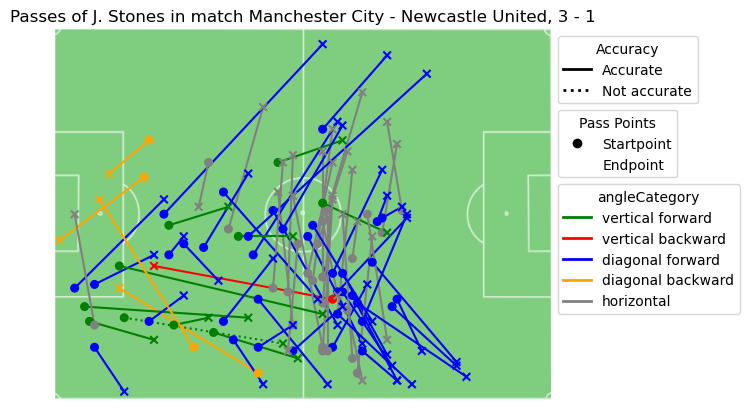

In [34]:
vis.plot_passes(
    df_events,
    df_players,
    df_matches,
    9380,
    2499954,
    'angleCategory'
)

Even though John Stones played as a center-back in his first seasons under Pep Guardiola, we can see that he was playing really high, as Manchester City was typically aiming to control games through possession and territory. Opponents were often pinned in their own half, with City recycling possession and patiently probing.

Let's now inspect the three players' passing-stats of the whole season starting with Sergio Ramos.

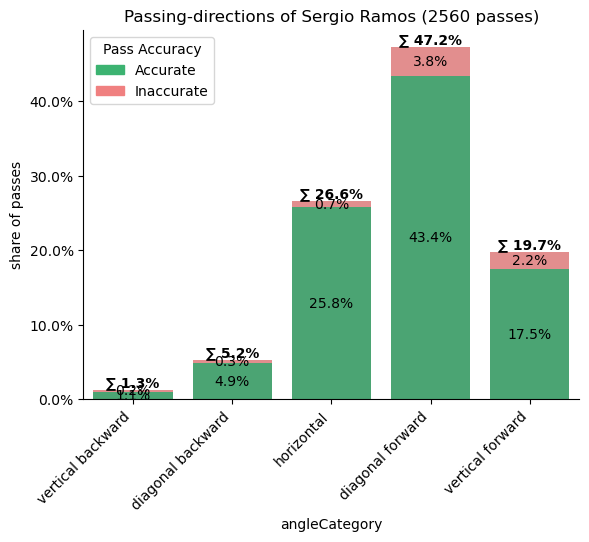

In [79]:
vis.plot_passing_stats(df_events, df_players, df_matches, 3306)

As we saw earlier when comparing the top-tier-passers, Ramos has an outstanding forward rate, playing over 60% of his passes forward while still having a high accuracy. 

Let's now have a look a Toni Kroos.

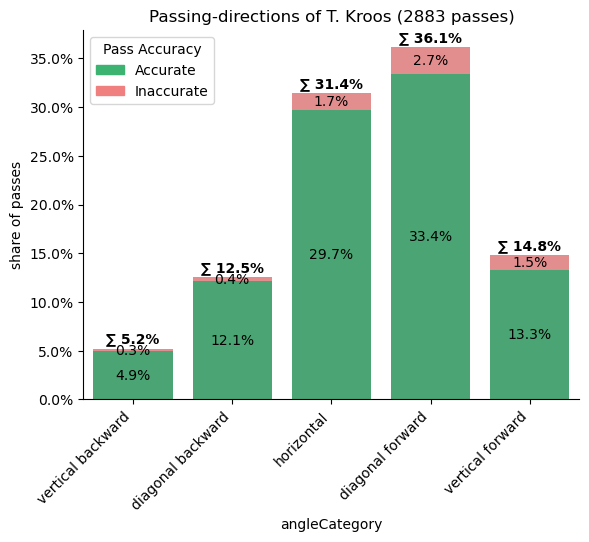

In [80]:
vis.plot_passing_stats(df_events, df_players, df_matches, 14723)

With nearly 2900 passes, Kroos has the highest pass-count of the three players. This makes his high forward rate and passing accuracy stand out even more, especially when taking into account, that as a central midfielder, he is under much more opponent-pressure as he is playing higher up on the pitch.

We finish the passing-analysis by looking at John Stones' stats.

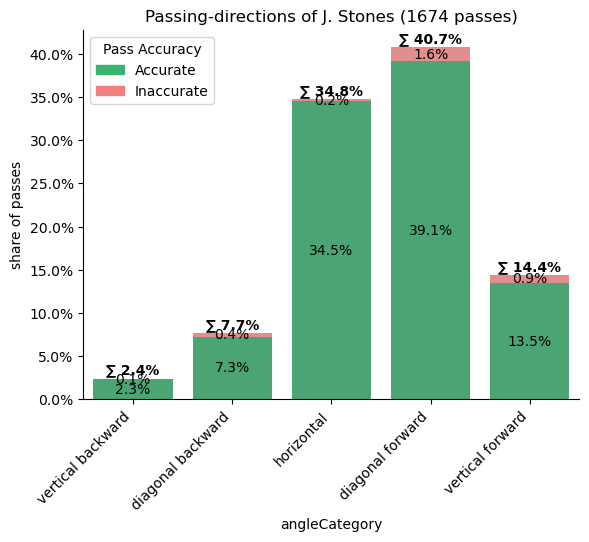

In [81]:
vis.plot_passing_stats(df_events, df_players, df_matches, 9380)

Stones didn't play as many passes as Ramos and Kroos while having the biggest share of horizontal passes of the three. Nevertheless, his overall passing accuracy of nearly 97% is extraordinary.

## Shot-analysis

Now we want to perform a logistic-regression on all of the shots in df_events (including free-kick-shots and penalties) in order to predict the goal-probability by position, angle, bodypart, previous event and so on.
To do so, we first create a new dataframe with only the shots.

In [35]:
df_shots = df_events[df_events['eventName'] == 'Shot'].copy()
df_freekicks = df_events[df_events['subEventName'] == 'Free kick shot'].copy()
df_penalties = df_events[df_events['subEventName'] == 'Penalty'].copy()

df_shots = pd.concat([df_shots, df_freekicks, df_penalties], axis=0)

Let's first visualize each of the feature's correlation to a shot's outcome.

To explore a single matches' shot, we can plot the position the shots were taken from and add some information about a specified feature.

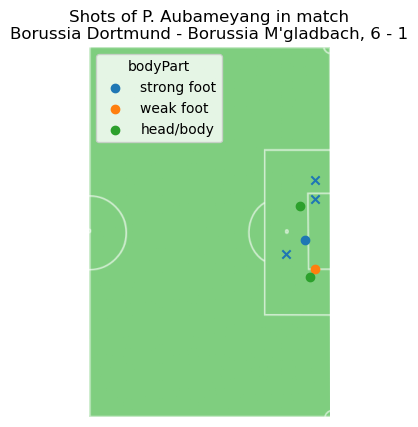

In [36]:
vis.plot_shots(
    df_shots,
    df_players,
    df_teams,
    df_matches,
    'bodyPart',
    True,
    2516785,
    2447,
    25867
)

Looking at Pierre Aubameyang's performance againts Borussia Mönchengladbach, we can see that he scored 3 out of his 4 shots taken with his strong foot, while his weak foot shots and headers didn't go in. The shots were all taken from inside the box.

Let's inspect how the body-part a shot is taken with affects the goal-probability.

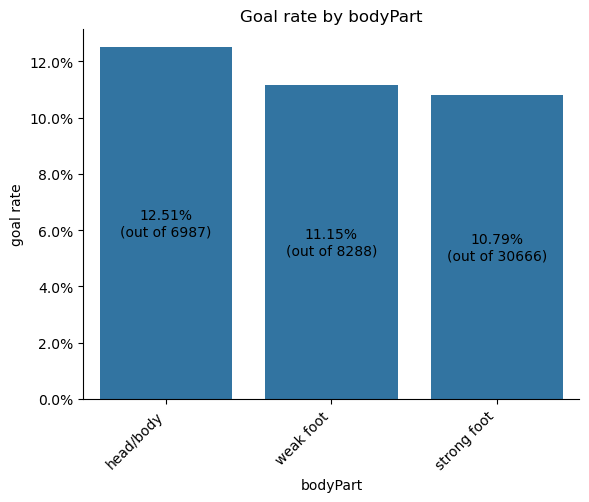

In [37]:
vis.feature_goal_corr_bars(df_shots, 'bodyPart', 5, False)

Suprprisingly it shows, that shots taken with the strong foot seem to have the least probability of leading to a goal, while shots with head/body have the highest goal rate. Looking at the number of shots taken with each bodypart puts this observation into perspective, as more than double the amount of shots were taken with the strong foot than with other bodyparts combined. Another important factor could be, headers or weak foot shots are typically taken from a smaller distance and a better angle to the goal, leading to a higher success rate. Let's inspect this.

Let's first see how distance and angle to goal affect goal-probability before investigating the shots' body-part distribution regarding distance and angle.

c:\Users\jwoeh\Documents\Data Science\Projekte\football_analysis\visualizations.py:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_shares = df.groupby(f'{feature}Bins')['goal'].mean()


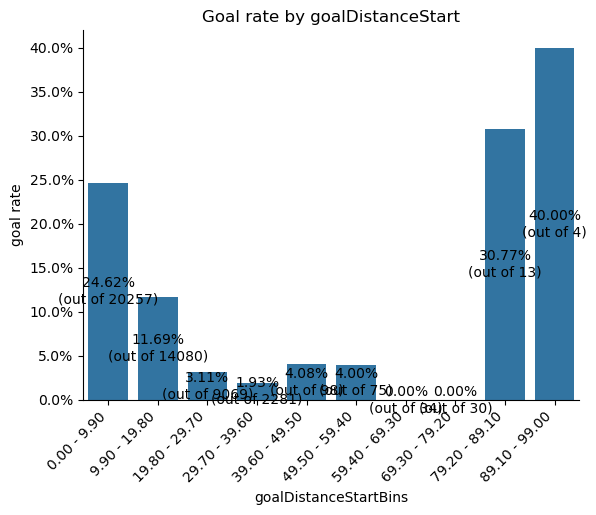

In [38]:
vis.feature_goal_corr_bars(df_shots, 'goalDistanceStart', 10, False)

Disregarding the shots from very far out (>80m) due to their small sample size (might even be wrongly recorded as I don't recall 14 goals from that far out in one season), we can clearly see that goal-rate decrease with increasing distance.

Next to distance, the angle to goal is also important when analysing shots.

c:\Users\jwoeh\Documents\Data Science\Projekte\football_analysis\visualizations.py:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_shares = df.groupby(f'{feature}Bins')['goal'].mean()


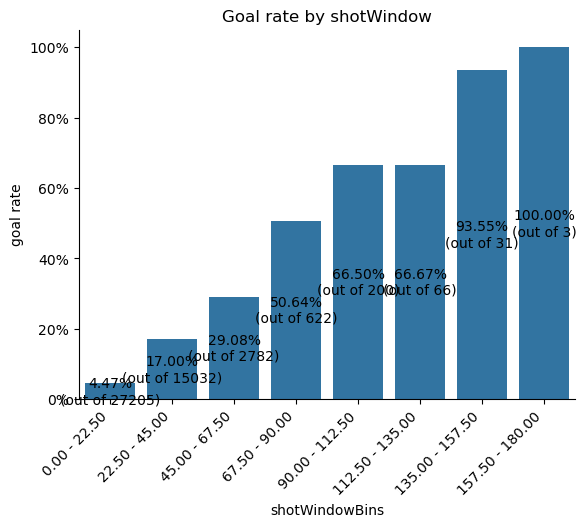

In [39]:
vis.feature_goal_corr_bars(df_shots, 'shotWindow', 8, False)

We see that goal-rates steadily increase with increasing shot-window (i.e. better angle).

Regarding these insights, let's inspect the bodyparts' shots' distance- and angle-distribution.

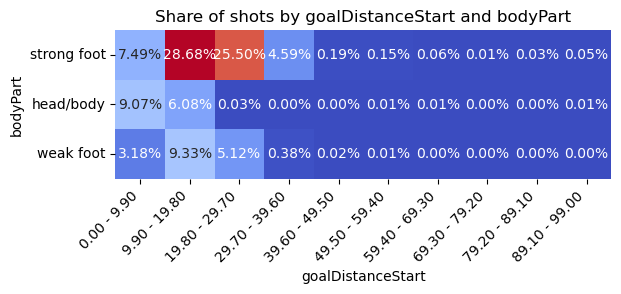

In [40]:
vis.category_heatmap(df_shots, 'goalDistanceStart', 'bodyPart', 10, 3)

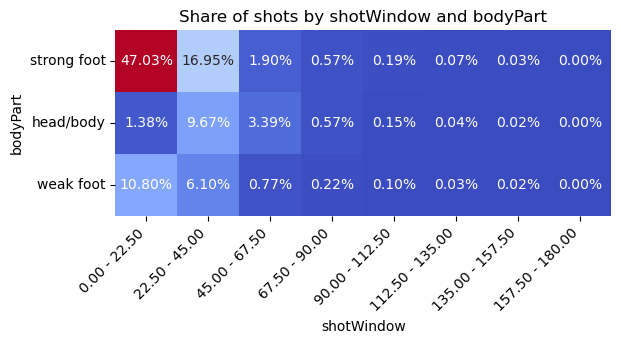

In [41]:
vis.category_heatmap(df_shots, 'shotWindow', 'bodyPart', 8, 3)

As assumed, the distances and angles shots are taken from are very different for each bodypart.

About 15% of the shots are headers/bodyshots, most of them were taken from a very close distance of less than 20m from the goal and with a shot-window-angle between 15 and 50 degrees.

A little more shots in total are taken with the weak foot, half of them from up to 15m from the goal, the other half from a range between 14m and 28m. Almost three out of four shots taken with the weak foot had a narrow shot-window of less than 15 degrees.

With about 66% in total, the biggest share of shots are taken with the strong foot, more than half of them from a range between 14m and 28m, followed by more than a third from a distance closer than 14m. Still around 8% of all shots are taken with the strong foot from more than 28m of distance to the goal. The shot's angles resemble the angles of weak-foot-shots with more than 3 out of 4 shots were taken from a bad angle, having a narrow shot-window of less than 15 degrees.

With this information, the bodyparts' goal-ratios don't seem that suprising anymore as the strong-foot-shots are mostly taken from worse distances and angles.

## Handling Outliers

Before tuning and training the model, let's look for outliers that could negatively affect the model's performance. We will do this considering the columns 'xPosStart', 'yPosStart', 'goalDistanceStart', 'bodyPart', and 'playerRole'.

As there are very few (only 7) shots taken from goalkeepers, we will drop them as the sample size is just too small to deduct anything meaningful from it.

In [42]:
goalkeeper_shots = df_shots[df_shots['playerRole'] == 'GKP']['subEventName']
df_shots.drop(goalkeeper_shots.index, inplace=True)
print(
    f'{goalkeeper_shots.shape[0]} goalkeeper shots removed from dataset.'
)

7 goalkeeper shots removed from dataset.


As seen in below histogram, there are only very few shots taken from a distance greater than 40 meters.

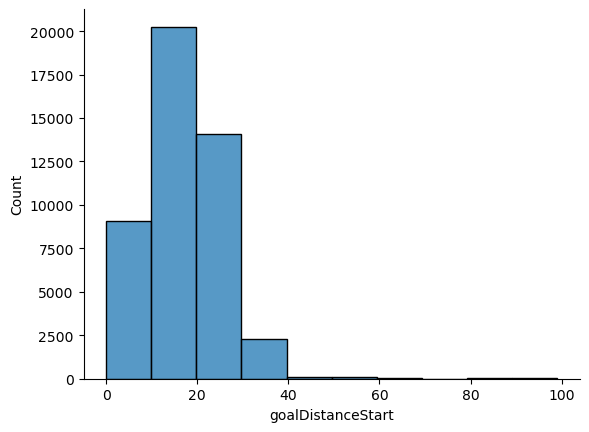

In [43]:
ax = sns.histplot(x=df_shots['goalDistanceStart'], bins=10)
sns.despine(right=True, top=True)


As those shots are only interesting when we know the goalkeeper's position (and as we also see below none of those shots is preceded by the event 'Goalkeeper leaving line' so we have no information about the goalkeeper's position).

In [44]:
max_distance_goalkeeper_out = df_shots[
    df_shots['prevEventName'] == 'Goalkeeper leaving line'
]['goalDistanceStart'].max()
print(
    f'Max shot distance with goalkeeper off line: '
    f'{max_distance_goalkeeper_out:.2f} m'
)

Max shot distance with goalkeeper off line: 33.63 m


So for a better general model-performance we will drop all of the shots taken from very far out (> 40m).

In [45]:
far_shots = df_shots[df_shots['goalDistanceStart'] > 40]
df_shots.drop(
    far_shots.index,
    inplace=True
)
print(
    f'{far_shots.shape[0]} far shots removed from dataset.'
)

249 far shots removed from dataset.


## xGoal-classification with Logistic Regression

Let's go ahead and create an xGoal-model. We will train and test the model using all of the leagues except the Bundesliga and then apply it on the Bundesliga to do some analysis using the xGoals.

We define the relevant features we will use for the regression according to our previous analysis.

In [57]:
relevant_cols = {
    'numerical': ['goalDistanceStart', 'shotWindow'],
    'boolean': [
        'prevDangerousBallLost', 'counterAttack',
        'prevThrough', 'prevHigh'
    ],
    'categorical': [
        'subEventName', 'bodyPart', 'prevEventName',
        'prevSubEventName', 'playerRole', 'competition'
    ]
}

X = df_shots[
    relevant_cols['numerical'] +
    relevant_cols['boolean'] +
    relevant_cols['categorical']
].copy()

y = df_shots['goal'].copy()

We seperate the bundesliga-data from the rest so we can later apply the trained model on it.

In [58]:
df_bundesliga = df_shots[
    df_shots['competition'] == 'germany'
].copy()

X.drop(df_bundesliga.index, inplace=True)
y.drop(df_bundesliga.index, inplace=True)

X.drop(columns=['competition'], inplace=True)
relevant_cols['categorical'].remove('competition')
df_bundesliga.drop(columns=['competition'], inplace=True)

We encode the categorical features using one-hot encoding.

In [59]:
ct = ColumnTransformer(
    transformers=[
        ('', OneHotEncoder(drop='first'), relevant_cols['categorical'])
    ],
    remainder='passthrough'
)
X = ct.fit_transform(X)
columns_transformed = ct.get_feature_names_out()
X = pd.DataFrame(X.toarray(), columns=columns_transformed)

Perform a gridsearch to find the best hyperparameters (may outcomment the big grid to save time)

In [60]:
model = LogisticRegression(random_state=42)

param_grid = {
    'C': np.logspace(-4, 4, 10),
    'class_weight': ['balanced', None],
    'max_iter': [250, 500, 750],
    'penalty': ['l1', 'l2', None],
    'solver': ['liblinear', 'newton-cholesky', 'saga']
}
param_grid = {
    'C': np.logspace(-2, 2, 8),
    'class_weight': ['balanced'],
    'max_iter': [500],
    'penalty': ['l2'],
    'solver': ['saga']
}
'''
Best Hyperparameters: {
    'C': np.float64(0.13894954943731375),
    'class_weight': 'balanced',
    'max_iter': 500,
    'penalty': 'l2',
    'solver': 'saga'
}
'''

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='precision',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X, y)

print('Best Hyperparameters:', grid_search.best_params_)
print('Best accuracy:', grid_search.best_score_)

Best Hyperparameters: {'C': 26.826957952797247, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Best accuracy: 0.2628437641942048


c:\Users\jwoeh\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [67]:
best_model = grid_search.best_estimator_
best_model.fit(X, y)

c:\Users\jwoeh\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=26.826957952797247, class_weight='balanced', max_iter=500,
                   random_state=42, solver='saga')

Let's take a look at the fitted models' coefficients to better understand what features are important when predicting a shot's outcome

In [68]:
feature_importance = pd.DataFrame(
    {'Feature': X.columns, 'Coefficient': best_model.coef_[0]}
)

feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(
    by='Abs_Coefficient',
    ascending=False
)

feature_importance[['Feature', 'Coefficient']].head(20)

,Feature,Coefficient
0,__subEventName_Penalty,1.264320
1,__subEventName_Shot,-0.842887
47,remainder__prevDangerousBallLost,0.830720
2,__bodyPart_strong foot,0.595733
49,remainder__prevThrough,0.591247
13,__prevSubEventName_Air duel,-0.523707
48,remainder__counterAttack,0.496237
3,__bodyPart_weak foot,0.467932
15,__prevSubEventName_Corner,-0.407054
14,__prevSubEventName_Clearance,-0.391916


Todo: Conclusion on feature-importance

## Applying the model on the Bundesliga

To analyse our traind model's performance, we apply it on the bundesliga-data.

In [69]:
df_bundesliga_transformed = ct.transform(df_bundesliga)
df_bundesliga_transformed = pd.DataFrame(
    df_bundesliga_transformed.toarray(),
    columns=columns_transformed
)

In [70]:
y_test = df_shots[df_shots['competition'] == 'germany']['goal']
y_pred = best_model.predict(df_bundesliga_transformed)
y_pred_probability = best_model.predict_proba(df_bundesliga_transformed)[:, 1]

Let's take a look at the fitted model's confusion-matrix. Besides the classes' sizes, let's also consider the xGoals-average (i.e. how 'sure' the model was of the predicted outcome)

In [71]:
def conf_matrix_avg_probability(
    y_test: pd.Series,
    y_pred: pd.Series,
    y_pred_proba: pd.Series
) -> None:
    conf_matrix = confusion_matrix(y_test, y_pred)

    df = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred,
        'probability': y_pred_proba
    })

    df_TN = df[~df['actual'] & ~df['predicted']]
    df_FP = df[~df['actual'] & df['predicted']]
    df_FN = df[df['actual'] & ~df['predicted']]
    df_TP = df[df['actual'] & df['predicted']]

    xgoals_avg_annot = [
        [
            f' / avg xG: {df_TN['probability'].mean():.2f}',
            f' / avg xG: {df_FP['probability'].mean():.2f}'
        ],
        [
            f' / avg xG: {df_FN['probability'].mean():.2f}',
            f' / avg xG: {df_TP['probability'].mean():.2f}'
        ]
    ]

    conf_matrix_annot = np.char.add(
        conf_matrix.astype(str),
        xgoals_avg_annot
    )

    ax = sns.heatmap(
        data=confusion_matrix(y_test, y_pred),
        annot=conf_matrix_annot,
        cbar=False,
        cmap='coolwarm',
        fmt='',
        square=True
    )

    ax.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
    ax.set_yticklabels(['Actual Negative', 'Actual Positive'])
    plt.title('Confusion matrix with average xG')
    return None

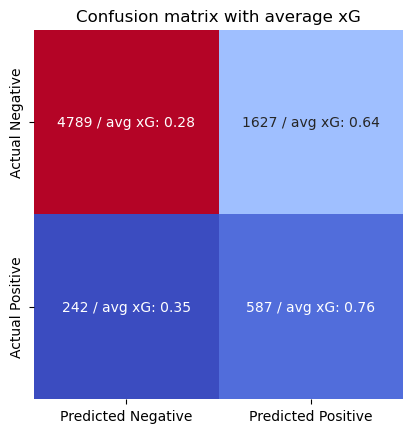

In [72]:
conf_matrix_avg_probability(y_test, y_pred, y_pred_probability)

As we can see, the model on average was close to predict the false negatives correctly as positives and the false positives correctly as negatives.

Let's investigate on what the table would have looked like at the end of the season following the xgoals.

In [73]:
df_matches_bundesliga = df_matches[
    df_matches['competition'] == 'germany'
].copy()

df_bundesliga['xG'] = y_pred_probability
xg_per_match = df_bundesliga.groupby(
    ['matchId', 'teamId']
)['xG'].sum()

First we have to compare each matches' xgoals to get the xWinner. We consider a xdraw-tolerance, meaning that xg-differences below a specified tolerance count as a draw.

In [74]:
xg_max = xg_per_match.groupby('matchId').max()
xg_min = xg_per_match.groupby('matchId').min()
xg_diff = xg_max - xg_min

x_winner = xg_per_match.groupby('matchId').idxmax().apply(lambda x: x[1])
x_winner = x_winner[xg_diff >= co.XDRAW_TOLERANCE]

df_matches_bundesliga['xWinner'] = (
    df_matches_bundesliga.index.to_series().apply(
        lambda x: x_winner[x] if x in x_winner else 0
    )
)

We now count the xwinners and xdraws to calculate each team's xpoints.

In [75]:
df_xwins = df_matches_bundesliga[
    df_matches_bundesliga['xWinner'] != 0
].copy()
xwin_points = df_xwins['xWinner'].value_counts() * 3

In [76]:
df_xdraws = df_matches_bundesliga[df_matches_bundesliga['xWinner'] == 0].copy()
df_xdraws['teamIds'] = df_xdraws['teamsData'].apply(
    lambda data: list(data.keys())
)
df_xdraws = df_xdraws.explode('teamIds')
xdraw_points = df_xdraws['teamIds'].astype(int).value_counts()

count xgoals scored/conceded

In [77]:
def xgoals_conceded(teamId: int) -> float:
    matches = df_bundesliga[
        df_bundesliga['teamId'] == teamId
    ]['matchId'].unique()
    df_matches_events = df_bundesliga[
        df_bundesliga['matchId'].isin(matches)
    ]
    df_opponent_events = df_matches_events[
        df_matches_events['teamId'] != teamId
    ]
    return df_opponent_events['xG'].sum().round(2)

In [78]:
total_xgoals = df_bundesliga.groupby('teamId')['xG'].sum().round(2)
total_xgoals_conceded = {
    teamId: xgoals_conceded(teamId)
    for teamId in df_bundesliga['teamId'].unique()
}

We calculate each team's actual points using the information about the matches' outcomes from the real data.

In [79]:
df_wins = df_matches_bundesliga[df_matches_bundesliga['winner'] != 0].copy()
win_points = df_wins['winner'].value_counts() * 3

In [80]:
df_draws = df_matches_bundesliga[df_matches_bundesliga['winner'] == 0].copy()
df_draws['teamIds'] = df_draws['teamsData'].apply(
    lambda data: list(data.keys())
)
df_draws = df_draws.explode('teamIds')
draw_points = df_draws['teamIds'].astype(int).value_counts()

To complete the data we need for our final table, we count the actual goals scored and conceded for each team.

In [81]:
def goals_scored(teamId: int) -> int:
    matches = df_bundesliga[
        df_bundesliga['teamId'] == teamId
    ]['matchId'].unique()
    goals = [
        df_matches_bundesliga.loc[match, 'teamsData'][str(teamId)]['score']
        for match in matches
    ]
    return sum(goals)

In [82]:
def goals_conceded(teamId: int) -> int:
    matches = df_bundesliga[
        df_bundesliga['teamId'] == teamId
    ]['matchId'].unique()
    goals_conceded = [
        df_matches_bundesliga.loc[match, 'teamsData'][
            ut.get_other_value(
                list(df_matches_bundesliga.loc[match, 'teamsData'].keys()),
                str(teamId)
            )
        ]['score']
        for match in matches
    ]
    return sum(goals_conceded)

In [83]:
total_goals = {
    teamId: goals_scored(teamId)
    for teamId in df_bundesliga['teamId'].unique()
}
total_goals_conceded = {
    teamId: goals_conceded(teamId)
    for teamId in df_bundesliga['teamId'].unique()
}

we now have all the information available and can start assembling our final table by putting together the actual data

In [84]:
table = pd.DataFrame({'teamId': df_bundesliga['teamId'].unique()})
table['name'] = table['teamId'].apply(lambda id: df_teams.loc[id, 'name'])
table['points'] = table['teamId'].apply(
    lambda id: win_points.get(id, 0) + draw_points.get(id, 0)
)
table['goals'] = table['teamId'].apply(lambda id: total_goals.get(id, 0))
table['goalsConceded'] = table['teamId'].apply(
    lambda id: total_goals_conceded.get(id, 0)
)
table['goalDiff'] = table['goals'] - table['goalsConceded']


To compare the actual with the expected outcome, we add the expected data

In [85]:
table['xPoints'] = table['teamId'].apply(
    lambda id: xwin_points.get(id, 0) + xdraw_points.get(id, 0)
)
table['xG'] = table['teamId'].apply(lambda id: total_xgoals.get(id, 0))
table['xGConceded'] = table['teamId'].apply(
    lambda id: total_xgoals_conceded.get(id, 0)
)
table['xGDiff'] = table['xG'] - table['xGConceded']
table['points_diff'] = table['points'] - table['xPoints']
table.set_index('teamId', inplace=True)

Calculate rank and xrank

In [86]:
for col, diff in [('points', 'goalDiff'), ('xPoints', 'xGDiff')]:
    table_sorted = table.sort_values(diff, ascending=False)
    table[f'{col}_rank'] = table_sorted[col].rank(
        ascending=False,
        method='first'
    ).astype(int)
table['rank_diff'] = table['xPoints_rank'] - table['points_rank']

Show table

In [87]:
table.sort_values(by='points_rank', ascending=True, inplace=True)
general_cols = ['name', 'points_diff', 'rank_diff']
actual_cols = ['points_rank', 'points', 'goals', 'goalsConceded', 'goalDiff']
expected_cols = ['xPoints_rank', 'xPoints', 'xG', 'xGConceded', 'xGDiff']
table[general_cols + actual_cols + expected_cols]

,name,points_diff,rank_diff,points_rank,points,goals,goalsConceded,goalDiff,xPoints_rank,xPoints,xG,xGConceded,xGDiff
teamId,,,,,,,,,,,,,
2444,Bayern München,-1,0,1,84,92,28,64,1,85,238.26,109.54,128.72
2449,Schalke 04,7,4,2,63,53,37,16,6,56,147.19,138.77,8.42
2482,Hoffenheim,-1,2,3,55,66,48,18,5,56,189.53,157.13,32.40
2447,Borussia Dortmund,-24,-1,4,55,64,47,17,3,79,200.46,145.06,55.40
2446,Bayer Leverkusen,-25,-3,5,55,58,44,14,2,80,198.79,129.20,69.59
2975,RB Leipzig,-8,-2,6,53,57,53,4,4,61,183.42,153.75,29.67
2445,Stuttgart,5,3,7,51,36,36,0,10,46,138.61,161.52,-22.91
2462,Eintracht Frankfurt,1,1,8,49,45,45,0,9,48,146.56,141.73,4.83
2454,Borussia M'gladbach,-2,-2,9,47,47,52,-5,7,49,176.14,190.56,-14.42


schauen wer am meisten über/unterperformt hat (Punkte, Tabellenplatz)

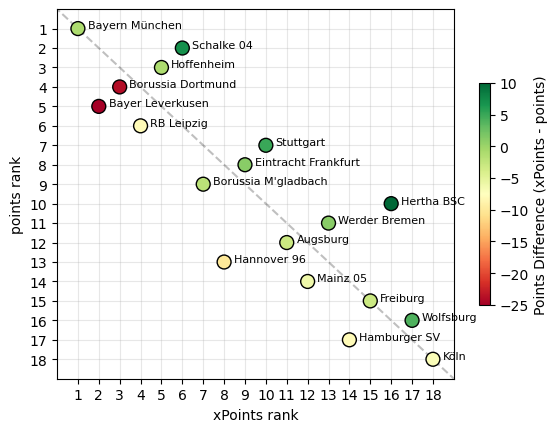

In [89]:
plt.plot(
    [-1, 19],
    [-1, 19],
    'k--',
    alpha=0.25
)
plt.grid(True, alpha=0.3)

scatter = plt.scatter(
    table['xPoints_rank'],
    table['points_rank'],
    c=table['points_diff'],
    cmap='RdYlGn',
    s=100,
    edgecolors='black',
    linewidths=1,
    zorder=5
)

for idx, row in table.iterrows():
    plt.annotate(
        row['name'],
        (row['xPoints_rank'], row['points_rank']),
        xytext=(7, 0),
        textcoords='offset points',
        fontsize=8,
        ha='left',
        zorder=6
    )

plt.colorbar(
    scatter,
    label='Points Difference (xPoints - points)',
    orientation='vertical',
    shrink=0.6
)
plt.xlabel('xPoints rank')
plt.ylabel('points rank')
plt.xlim(0, 19)
plt.ylim(0, 19)
plt.xticks(range(1, 19))
plt.yticks(range(1, 19))
plt.gca().invert_yaxis()
plt.show()

Todo: Draw conclusion on the table-differences

Todo: Overall conclusion, outlook and possible extensions
- Cool dataset
- missing: information about opponent's posistioning (is the player surrounded by opponents or free)
- Possible extensions: 
    - Compare xgoals to goals per player
    - deduct xAssists and compare them to assists per player
    - compare xgoals conceded to goals conceded per goalkeeper
    - Compare pre/post-shot xG-model (with / without considering where the shots were aimed)
    - try different models